#  Прогнозирование количества заказов такси в аэропортах

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Используемые-библиотеки" data-toc-modified-id="Используемые-библиотеки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Используемые библиотеки</a></span></li><li><span><a href="#Загрузка-данных-и-подготовка" data-toc-modified-id="Загрузка-данных-и-подготовка-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Загрузка данных и подготовка</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Тренд" data-toc-modified-id="Тренд-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Тренд</a></span></li><li><span><a href="#Сезонность" data-toc-modified-id="Сезонность-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Сезонность</a></span></li><li><span><a href="#Остатки-декомпозиции" data-toc-modified-id="Остатки-декомпозиции-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Остатки декомпозиции</a></span></li></ul></li><li><span><a href="#Подготовка-данных-для-обучения" data-toc-modified-id="Подготовка-данных-для-обучения-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Подготовка данных для обучения</a></span><ul class="toc-item"><li><span><a href="#Генерация-признаков" data-toc-modified-id="Генерация-признаков-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Генерация признаков</a></span></li><li><span><a href="#Разбиение-выборок-на-обучающую-и-тестовую" data-toc-modified-id="Разбиение-выборок-на-обучающую-и-тестовую-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Разбиение выборок на обучающую и тестовую</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Описание проекта

Компания "Чётенькое такси" собрала исторические данные о заказах такси в аэропортах с целью привлечения большего числа водителей в периоды пиковой нагрузки. Для достижения этой цели необходимо построить модель, способную предсказывать количество заказов такси на следующий час.

В рамках проекта требуется выполнить следующие шаги:

1. Загрузка данных и их ресемплирование по одному часу.
2. Анализ данных.
3. Обучение различных моделей с различными гиперпараметрами. Для оценки качества моделей необходимо создать тестовую выборку, размер которой составляет 10% от исходных данных.
4. Проверка данных на тестовой выборке и выводы.

## Описание данных

Входные данные лежат в файле taxi.csv, где количество заказов записано в столбце "num_orders" (от англ. "number of orders", что означает "число заказов").

Метрика RMSE (Root Mean Square Error) на тестовой выборке должна быть не больше 48.

## Используемые библиотеки

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool


RANDOM_SEED = np.random.RandomState(15071997)

In [2]:
def make_plot(data):
    data.plot(figsize=(14,6))
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов')
    plt.show()

## Загрузка данных и подготовка

In [3]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
    
data.sort_index(inplace=True)

In [4]:
# выполним ресемплирование
data = data.resample('1H').sum()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [6]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
print('Начало временного ряда:', data.index.min())
print('Конец временного ряда:', data.index.max())

Начало временного ряда: 2018-03-01 00:00:00
Конец временного ряда: 2018-08-31 23:00:00


После ресемплирование данных (по одному часу) получили 4416 непустых временных точек, содержащих количество заказов. Данные начинаются с марта 2018 и заканчиваются августом 2018 (включительно)

## Анализ данных

Для начала посмотрим как выглядят данные после ресемплирования

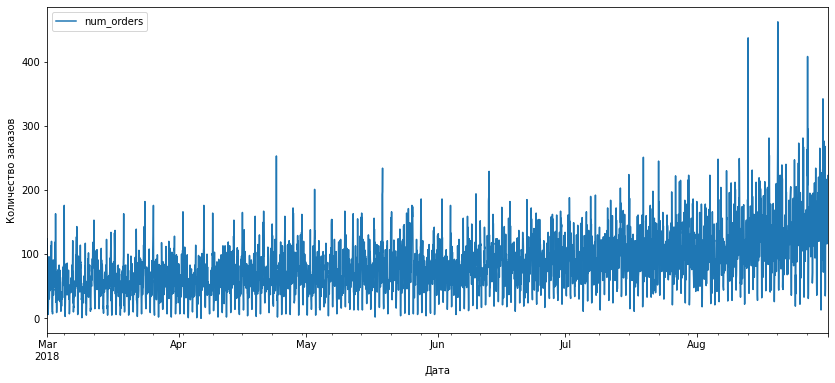

In [8]:
make_plot(data)

Из анализа графика можно сделать вывод, что ряд данных содержит выбросы, которые оказывают влияние на разброс. Выделим тренд, сезонную составляющую и остатки декомпозиции

### Тренд

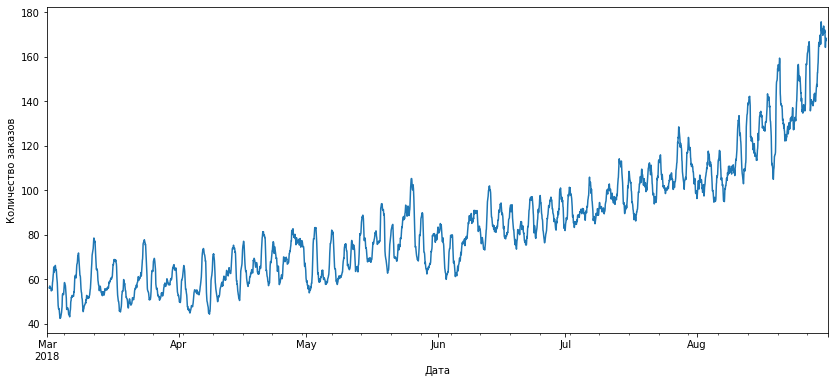

In [9]:
decomposed = seasonal_decompose(data)

make_plot(decomposed.trend)

### Сезонность

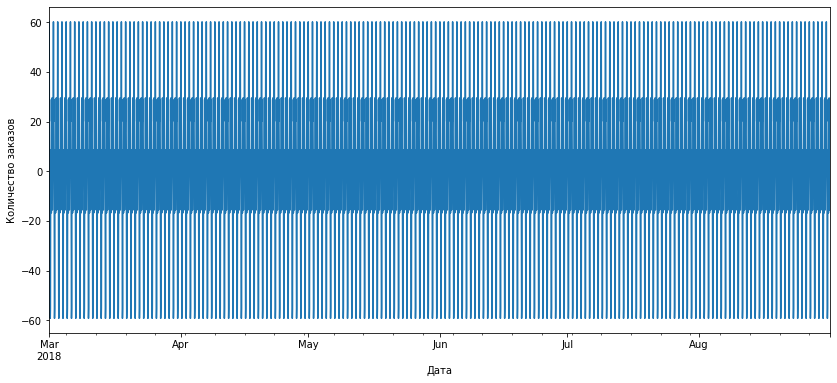

In [10]:
make_plot(decomposed.seasonal)

Возьмем отрезок данных для того, чтобы график был различим

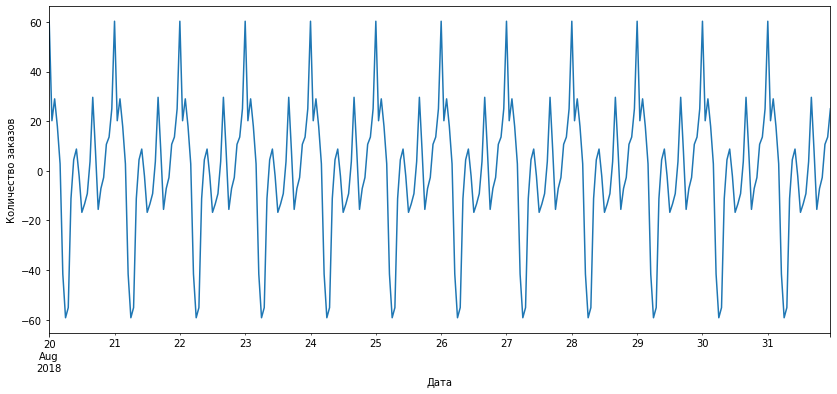

In [11]:
make_plot(decomposed.seasonal['2018-08-20':])

### Остатки декомпозиции

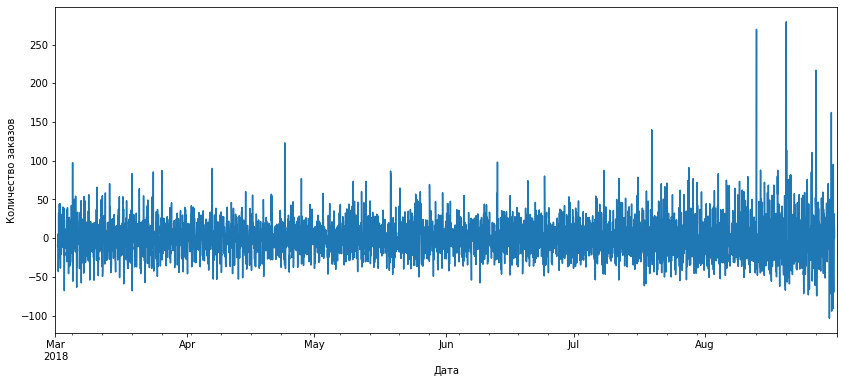

In [12]:
make_plot(decomposed.resid)

**Выводы:**

Наблюдается растущий тренд, таким образом, временной ряд не является стационарным, так как у него меняется среднее значение

В течение дня наблюдается сезонность в количестве заказов: снижение ночью и максимальные значения ночью с ростом днем

## Подготовка данных для обучения

### Генерация признаков

In [13]:
def make_features(data):
    df = data.copy()
    # создание признаков на основе даты
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    df['hour'] = df.index.hour

    # создание статистических признаков
    df['rolling_mean'] = df['num_orders'].shift(24).rolling(window=5).mean()
    df['rolling_sum'] = df['num_orders'].shift(24).rolling(window=5).sum()

    # добавление лаговых признаков
    df['lag_24'] = df['num_orders'].shift(24)

    # создание категориальных признаков
    df['hour_category'] = pd.cut(df['hour'], bins=4, labels=[1, 2, 3, 4])
    df['hour_category'] = df['hour_category'].astype('int')

    #удалим пустые строки
    df = df.dropna()
    
    return df

df = make_features(data)

### Разбиение выборок на обучающую и тестовую

In [14]:
X = df.drop(columns=['num_orders'])
y = df['num_orders']

In [15]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, shuffle=False, test_size=0.3, random_state=RANDOM_SEED)

Данные разбиты на обучающую и тестовую выборки, а также сгенерированы признаки для дальнейшего обучения моделей

## Обучение

### Линейная регрессия

In [16]:
models = {}

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_val)

lr_rmse = mean_squared_error(y_val, lr_pred, squared=False)

models['LinearRegression'] = lr_rmse
print('RMSE на валидационной выборке (LinearRegression):', lr_rmse)

RMSE на валидационной выборке (LinearRegression): 33.42570582839128


### Случайный лес

In [17]:
# rf_model = RandomForestRegressor(criterion='mse',
#                                  random_state=RANDOM_SEED,
#                                  n_estimators = 100,
#                                  n_jobs=-1)
# rf_model.fit(X_train, y_train)
# rf_pred = rf_model.predict(X_val)

# rf_rmse = mean_squared_error(y_val, rf_pred, squared=False)

# models['RandomForestRegressor'] = rf_rmse
# print('RMSE на валидационной выборке (LinearRegression):', rf_rmse)

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Вот тут не могу понять, поскольку выполнял проект именно на платформе Яндекса и у меня он отрабатывает без ошибок... Закомменчу данную модель
</div> 

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    

### LightGBM

In [18]:
%%time
train_data = lgb.Dataset(X_train, label=y_train)

tscv = TimeSeriesSplit(n_splits=5)

# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.1
# }

# param_grid = {
#     'max_depth': [5, 10, 15],
#     'min_child_samples': [10, 20, 30],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }

# lgb_model = lgb.LGBMRegressor()

# random_search = RandomizedSearchCV(lgb_model,
#                                    param_distributions=param_grid,
#                                    n_iter=10, scoring='neg_root_mean_squared_error',
#                                    cv=tscv, verbose=1)

# # обучение модели с подобранными гиперпараметрами
# random_search.fit(X_train, y_train)

# # получение лучших гиперпараметров
# best_params = random_search.best_params_

# # обновление параметров модели с лучшими гиперпараметрами
# params.update(best_params)
# print(params)

#output
# Fitting 5 folds for each of 10 candidates, totalling 50 fits
# CPU times: user 57 s, sys: 477 ms, total: 57.4 s
# Wall time: 57.8 s
    
# {'objective': 'regression',
#  'metric': 'rmse',
#  'boosting_type': 'gbdt',
#  'learning_rate': 0.1,
#  'subsample': 0.8,
#  'min_child_samples': 30,
#  'max_depth': 5,
#  'colsample_bytree': 0.9}

CPU times: user 418 µs, sys: 109 µs, total: 527 µs
Wall time: 79.4 µs


In [19]:
params = {
    'objective': 'regression',
     'metric': 'rmse',
     'boosting_type': 'gbdt',
     'learning_rate': 0.1,
     'subsample': 0.8,
     'min_child_samples': 30,
     'max_depth': 5,
     'colsample_bytree': 0.9,
     'num_leaves': 6
}

lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model = lgb.train(params, train_data)
lgb_pred = lgb_model.predict(X_val)

lgb_rmse = mean_squared_error(y_val, lgb_pred, squared=False)

models['LightGBM'] = lgb_rmse
print('RMSE на валидационной выборке (LinearRegression):', lgb_rmse)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 2764, number of used features: 7
[LightGBM] [Info] Start training from score 68.595514
RMSE на валидационной выборке (LinearRegression): 34.05148740189274


### CatBoost

In [20]:
# подберем гиперпараметры
catboost_model = CatBoostRegressor(loss_function='RMSE',
                                  verbose=200)

parameters_cat = {'depth': [5, 10], 'learning_rate': np.arange(0.1, 1)}
catboost_model = catboost_model.grid_search(parameters_cat,
            Pool(X_train, y_train),
            cv=tscv,
            verbose=50,
            plot=False)

params = catboost_model['params']

0:	learn: 67.4162468	test: 80.9893111	best: 80.9893111 (0)	total: 47.2ms	remaining: 47.1s
200:	learn: 16.6020643	test: 23.3753235	best: 23.2793338 (179)	total: 211ms	remaining: 837ms
400:	learn: 14.5499224	test: 23.6672758	best: 23.2793338 (179)	total: 360ms	remaining: 538ms
600:	learn: 13.1365861	test: 24.3317968	best: 23.2793338 (179)	total: 535ms	remaining: 355ms
800:	learn: 12.0863321	test: 24.6958092	best: 23.2793338 (179)	total: 697ms	remaining: 173ms
999:	learn: 11.2813489	test: 24.8928008	best: 23.2793338 (179)	total: 845ms	remaining: 0us

bestTest = 23.27933376
bestIteration = 179

0:	loss: 23.2793338	best: 23.2793338 (0)	total: 1.31s	remaining: 1.31s
0:	learn: 67.7870412	test: 82.1176769	best: 82.1176769 (0)	total: 12.4ms	remaining: 12.4s
200:	learn: 11.8884516	test: 25.4362042	best: 25.3825199 (182)	total: 1.53s	remaining: 6.07s
400:	learn: 8.3444194	test: 25.6151092	best: 25.3725790 (207)	total: 3.03s	remaining: 4.53s
600:	learn: 6.3681859	test: 25.8675247	best: 25.3725790 

In [21]:
# обучим модель с наилучшими параметрами
catboost_model = CatBoostRegressor(loss_function='RMSE',
                                   depth=params['depth'],
                                   learning_rate=params['learning_rate'],
                                   verbose=200,
                                   random_seed=15071997)
catboost_model.fit(X_train, y_train)

catboost_pred = catboost_model.predict(X_val)
catboost_rmse = mean_squared_error(y_val, catboost_pred, squared=False)

models['CatboostRegressor'] = catboost_rmse

print('RMSE на валидационной выборке (CatBoost):', catboost_rmse)

0:	learn: 32.3632834	total: 998us	remaining: 997ms
200:	learn: 17.4417184	total: 167ms	remaining: 664ms
400:	learn: 15.4721925	total: 365ms	remaining: 545ms
600:	learn: 14.2472523	total: 527ms	remaining: 350ms
800:	learn: 13.2333955	total: 686ms	remaining: 170ms
999:	learn: 12.4690999	total: 848ms	remaining: 0us
RMSE на валидационной выборке (CatBoost): 34.04023224112189


In [22]:
pd.DataFrame(index=models.keys(), columns=['validation'], data=models.values())

,validation
LinearRegression,33.425706
LightGBM,34.051487
CatboostRegressor,34.040232


По результатам построения моделей и оценки их на валидационной выборки наилучшим образом показали себя модели LightGBM и модель CatBoost. Отберем как наилучшую модель CatBoost'a и обучим ее на полной выборке, а затем оценим на тестовом датасете. Модель достаточно быстро обучается и показывает самый низкий показатель rmse.

## Тестирование

In [23]:
# объединим обучающую и валидационную выборки
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

catboost_model = CatBoostRegressor(loss_function='RMSE',
                                  verbose=1000)
# обновим гиперпараметры
parameters_cat = {'depth': [5, 10], 'learning_rate': np.arange(0.1, 1)}
catboost_model = catboost_model.grid_search(parameters_cat,
            Pool(X_train_full, y_train_full),
            cv=tscv,
            verbose=50,
            plot=False)

params = catboost_model['params']

# обучим модель с наилучшими гиперпараметрами
catboost_model = CatBoostRegressor(loss_function='RMSE',
                                   depth=params['depth'],
                                   learning_rate=params['learning_rate'],
                                   verbose=1000,
                                   random_seed=15071997)
catboost_model.fit(X_train_full, y_train_full)

catboost_pred = catboost_model.predict(X_test)
catboost_rmse = mean_squared_error(y_test, catboost_pred, squared=False)

print('-'*100)
print('RMSE на тестовой выборке (CatBoost):', catboost_rmse)

0:	learn: 72.7891129	test: 106.9022137	best: 106.9022137 (0)	total: 1.11ms	remaining: 1.11s
999:	learn: 13.0826330	test: 33.0111260	best: 32.9363726 (668)	total: 851ms	remaining: 0us

bestTest = 32.93637265
bestIteration = 668

0:	loss: 32.9363726	best: 32.9363726 (0)	total: 1.2s	remaining: 1.2s
0:	learn: 72.9091811	test: 109.1240730	best: 109.1240730 (0)	total: 8.57ms	remaining: 8.56s
999:	learn: 5.3802486	test: 34.9372383	best: 34.8534974 (423)	total: 7.98s	remaining: 0us

bestTest = 34.85349744
bestIteration = 423

1:	loss: 34.8534974	best: 32.9363726 (0)	total: 9.21s	remaining: 0us
Estimating final quality...
Training on fold [0/5]
0:	learn: 59.1673852	test: 64.3429668	best: 64.3429668 (0)	total: 684us	remaining: 683ms
999:	learn: 5.4722481	test: 22.0557824	best: 21.3480761 (126)	total: 502ms	remaining: 0us

bestTest = 21.34807608
bestIteration = 126

Training on fold [1/5]
0:	learn: 61.1876672	test: 72.7127476	best: 72.7127476 (0)	total: 698us	remaining: 698ms
999:	learn: 8.441235

В результате тестирования модели получили RMSE на тестовой выборке равную 46. Исходя из условий задачи модель CatBoost соответствует нашим условиям. 

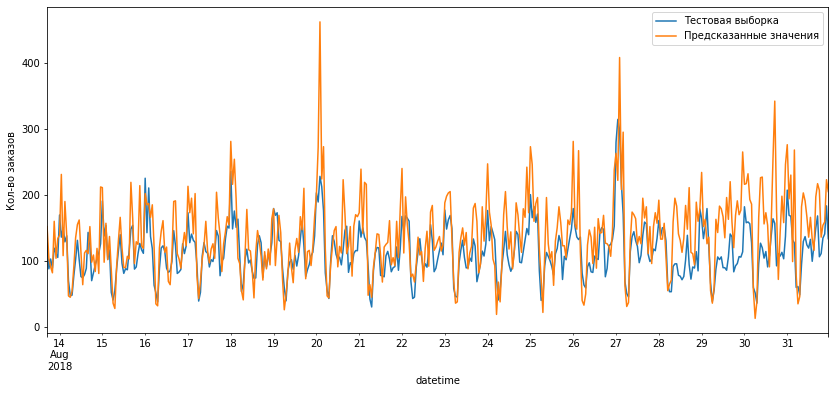

In [24]:
pd.Series(catboost_pred, index=y_test.index).plot(figsize=(14,6))
y_test.plot()
plt.ylabel('Кол-во заказов')
plt.legend(['Тестовая выборка', 'Предсказанные значения'])
plt.show()

На графике наглядно видно, что в целом линия графика предсказанных значений повторяет тестовую выборку

## Общий вывод

В результате выполнения проекта для компании "Чётенькое такси" была успешно построена модель, способная предсказывать количество заказов такси на следующий час. Были выполнены все запланированные шаги, включая загрузку и ресемплирование данных, анализ данных, создание тестовой, обучающей и валидационной выборки, обучение различных моделей с разными гиперпараметрами, а также тестирование лучшей модели. 

Качество моделей было оценено с использованием тестовой выборки, размер которой составлял 10% от исходных данных. Из результатов проверки видно, что модель дала достаточно точные предсказания (RMSE 46), что позволит компании привлечь больше водителей и улучшить сервис в периоды пиковой нагрузки. 

Таким образом, в ходе проекта была достигнута цель - помочь компании "Чётенькое такси" оптимизировать работу и привлечь больше водителей в периоды повышенной потребности в такси в аэропортах.